In [3]:
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
from src import ExpectationMaximization
import utils as utils

data_path = Path.cwd().parent / 'data/P2_data'

### What The lady asked
- benchmark: K-means
- innitialization: random vs k-means
- modalities: T1-w vs T1-w+FLAIR
- metrics: DSC, num iterations, comp.time

In [202]:
from distutils.ccompiler import new_compiler
import logging
from os import replace
from re import A
import numpy as np
from typing import Union, Tuple
from sklearn.cluster import KMeans, MeanShift
from scipy.stats import multivariate_normal
from tqdm import tqdm
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(message)s')

def our_multivariate_normal_pdf(x, means, sigmas):
    n_feats = means.shape[1] if np.ndim(means) > 1 else 1
    constant = 1/(((2*np.pi) ** n_feats/2) * (np.linalg.det(sigmas) ** 1/2))
    dif = x - means
    if (np.linalg.det(sigmas) != 0):
        mahalanobis_dist = np.sum(np.square(np.dot(dif, np.linalg.inv(sigmas))), axis=-1)
    else:
        mahalanobis_dist = np.sum(np.square(np.dot(dif, np.linalg.pinv(sigmas))), axis=-1)
    return constant * np.exp(-(1/2)*mahalanobis_dist)


def gaussian_likelihood(x, means, sigmas, use_our_gauss_likelihood):
    n_components, n_feats = means.shape
    n_samples = x.shape[0]
    if use_our_gauss_likelihood:
        likelihood = [our_multivariate_normal_pdf(
            x, means[i, :], sigmas[i, :, :]) for i in range(n_components)]
    else:
        likelihood = [multivariate_normal.pdf(
            x, means[i, :], sigmas[i, :, :], allow_singular=True) for i in range(n_components)]
    return np.asarray(likelihood).T


class ExpectationMaximization():
    def __init__(
        self,
        n_components: int = 3,
        mean_init: Union[str, np.ndarray] = 'random',  # array, 'k-means'
        priors: Union[str, np.ndarray] = 'non_informative',
        hard_em: bool = True,
        max_iter: int = 100,
        change_tol: float = 1e-5,
        seed: float = 420,
        verbose: bool = False,
        start_single_cov: bool = False,
        plot_rate: int = None,
        use_our_gauss_likelihood: bool = False
    ) -> None:

        self.n_components = n_components
        self.mean_init = mean_init
        self.priors = priors
        self.change_tol = change_tol
        self.max_iter = max_iter
        self.seed = seed
        self.verbose = verbose
        self.start_single_cov = start_single_cov
        self.plot_rate = plot_rate
        self.fitted = False
        self.hard_em = hard_em
        self.use_our_gauss_likelihood = use_our_gauss_likelihood

        # Check kind of priors to be used
        condition_one = isinstance(priors, str) and (priors not in ['non_informative'])
        condition_two = isinstance(priors, np.ndarray) and (priors.size != n_components)
        if condition_one or condition_two:
            raise Exception(
                "Priors must be either 'non_informative' or an array of "
                "'n_components' elements"
            )

        # Check kind of means to be used
        mean_options = ['radom', 'kmeans', 'mean_shifts']
        condition_one = isinstance(mean_init, str) and (mean_init not in mean_options)
        condition_two = isinstance(priors, np.ndarray) and (priors.size != n_components)
        if condition_one or condition_two:
            raise Exception(
                "Priors must be either 'random', 'kmeans', ' mean_shifts', or "
                "an array of 'n_components' rows, and n_features number of columns"
            )

    def fit(self, x: np.ndarray):
        self.fitted = True
        self.x = x
        self.n_samples, self.n_feat = x.shape
        self.labels = np.zeros((self.n_samples, self.n_components))

        self.priors_type = 'Provided array'
        if isinstance(self.priors, str) and (self.priors == 'non_informative'):
            self.priors = np.ones((self.n_components, 1)) / self.n_components
            self.priors_type = 'Non Informative'

        # Define kind of means to be used
        self.mean_type = 'Passed array'
        if isinstance(self.mean_init, str):
            if self.mean_init == 'radom':
                rng = np.random.default_rng(seed=self.seed)
                self.means = rng.integers(0, 255, (self.n_components, self.n_feat))
                self.mean_type = 'Random Init'
                idx = rng.choice(self.n_samples, size=self.n_components, replace=False)
                self.posteriors[idx, np.arange(self.n_components)] = 1
            elif self.mean_init == 'kmeans':
                kmeans = KMeans(
                    n_clusters=self.n_components, random_state=self.seed).fit(self.x)
                self.means = kmeans.cluster_centers_
                self.mean_type = 'K-Means'
                self.labels[np.arange(self.n_samples), kmeans.labels_] = 1
            else:
                mean_shift = MeanShift().fit(self.x)
                self.means = mean_shift.cluster_centers_
                self.n_components = self.means.shape[0]
                self.mean_type = 'Mean Shifts'
                self.labels = \
                    self.labels[np.arange(self.n_samples), mean_shift.labels_] = 1
        else:
            self.means = self.mean_init
            idx = rng.choice(self.n_samples, size=self.n_components, replace=False)
            self.labels[idx, np.arange(self.n_components)] = 1

        # Define initial covariance matrix
        _, self.sigmas, self.counts = self.estimate_mean_and_cov(
            self.x, self.labels, means=self.means, start_single_cov=self.start_single_cov)
        
        # Log initial info
        if self.verbose:
            logging.info('Starting Expectation Maximization Algorithm')
            logging.info(f'Priors type: {self.priors_type} \n {self.priors}')
            logging.info(f'Mean type: {self.mean_type} \n {self.means}')

        # Expectation Maximization process
        self.expectation_maximization()
        self.cluster_centroids = self.means

    def predict(self, x: np.ndarray) -> np.ndarray:
        if not self.fitted:
            raise Exception('Algorithm hasn\'t been fitted')
        self.expectation()
        self.predictions = np.argmax(self.posteriors, 1)
        return self.predictions
    
    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        if not self.fitted:
            raise Exception('Algorithm hasn\'t been fitted')
        self.expectation()
        return self.posteriors

    def fit_predict(self, x: np.ndarray) -> np.ndarray:
        self.fit(x)
        self.predictions = self.predict(self.x)
        return self.predictions

    def expectation_maximization(self):
        prev_log_lkh = 0
        for it in tqdm(range(self.max_iter), disable=self.verbose):
            # E-step
            self.expectation()

            # Scatter plots to see the evolution
            if self.plot_rate is not None:
                self.plots(it)

            # Check stop criteria: tolerance over log-likelihood
            for i in range(self.n_components):
                self.likelihood[:, i] = self.likelihood[:, i] * self.priors[i]
            log_lkh = np.sum(np.log(np.sum(self.likelihood, 1)), 0)
            difference = abs(prev_log_lkh - log_lkh)
            prev_log_lkh = log_lkh
            if difference < self.change_tol:
                break

            # M-Step
            self.maximization()
            if self.verbose:
                logging.info(f'Iteration: {it} - Log likelihood change: {difference}')
    
    def expectation(self):
        self.likelihood = gaussian_likelihood(
            self.x, self.means, self.sigmas, self.use_our_gauss_likelihood)
        num = np.asarray([self.likelihood[:, j] * self.priors[j] for j in range(self.n_components)]).T
        denom = np.sum(num, 1)
        self.posteriors = np.asarray([num[:, j] / denom for j in range(self.n_components)]).T

    def maximization(self):
        self.counts = np.sum(self.labels, 0)
        self.priors = self.counts / len(self.x)
        if self.hard_em:
            self.labels = np.zeros((self.x.shape[0], self.n_components))
            self.labels[np.arange(self.n_samples), np.argmax(self.posteriors, axis=1)] = 1
            self.means, self.sigmas, _ = self.estimate_mean_and_cov(self.x, self.labels)
            self.priors = self.counts / len(self.x)
        else:
            self.posteriors = self.posteriors * self.labels
            weithed_avg = np.dot(self.posteriors.T, self.x)
            self.means = weithed_avg / self.counts[:, np.newaxis]
            mea = np.dot(self.labels.T, self.x) / self.counts[:, np.newaxis]
            self.sigmas = np.zeros((self.n_components, self.n_feat, self.n_feat))
            for i in range(self.n_components):
                diff = self.x - self.means[i, :]
                weighted_diff = self.posteriors[:, i][:, np.newaxis] * diff
                self.sigmas[i] = np.dot(weighted_diff.T, diff) / self.counts[i]

    @staticmethod
    def estimate_mean_and_cov(x, labels, means=None, cov_reg=1e-6, start_single_cov=False):
        n_components = labels.shape[1]
        n_feat = x.shape[1]
        min_val = 10 * np.finfo(labels.dtype).eps
        counts = labels.sum(axis=0) + min_val
        means = np.dot(labels.T, x) / counts[:, np.newaxis]
        if start_single_cov:
            sigmas = np.cov(x.T)
            sigmas = np.repeat(sigmas[np.newaxis, :], n_components, 0)
        else:
            sigmas = np.zeros((n_components, n_feat, n_feat))
            for i in range(n_components):
                diff = x - means[i, :]
                sigmas[i] = np.dot(
                    (labels[:, i][:, np.newaxis] * diff).T, diff) / counts[i]
                # Avoid singular matrices
                sigmas[i].flat[:: n_feat + 1] += cov_reg
        if np.ndim(sigmas) == 1:
            sigmas = (sigmas[:, np.newaxis])[:, np.newaxis]
        return means, sigmas, counts

    def plots(self, it):
        if (it % 10) == 0:
            predictions = np.argmax(self.posteriors, 1)
            if self.n_feat == 1:
                fig, ax = plt.subplots()
                ax = sns.histplot(
                    x=self.x[:,0], hue=predictions, kde=False, bins=255,
                    stat='probability')
                n = 10000
                fit_x = np.zeros((3*n, 2))
                for i in range(self.n_components):
                    fit_x[i*n:(i+1)*n, 0] = np.random.normal(
                        loc=self.means[i], scale=self.sigmas[i][0], size=n)
                    fit_x[i*n:(i+1)*n, 1] = i
                ax = sns.histplot(
                    x=fit_x[:, 0], element='poly', kde=False, hue=fit_x[:, 1],
                    stat='probability')
                plt.show()
            else:
                plt.figure()
                sns.scatterplot(x=self.x[:, 0], y=self.x[:, 1], hue=predictions)
                plt.show()
                if it == 10:
                    plt.figure()
                    indx = np.random.choice(np.arange(self.x.shape[0]), 1000, False)
                    sample = self.x[indx, :]
                    sns.kdeplot(x=sample[:,0], y=sample[:,1])
                    plt.show()


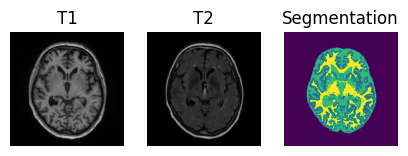

In [204]:
import SimpleITK as sitk
from pathlib import Path

from sklearn.cluster import k_means
import utils
from sklearn.mixture import GaussianMixture

data_path = Path('/home/jseia/Desktop/MAIA/Clases/spain/misa/misa_lab/data/P2_data')

def brain_tissue_segmentation(t1, t2, brain_mask):
    t1_vector = t1[brain_mask == 255].flatten()
    t2_vector = t2[brain_mask == 255].flatten()
    data = np.array([t1_vector, t2_vector]).T
    # data = np.expand_dims(t1_vector.T, 1)
    em = ExpectationMaximization(
        n_components=3, mean_init='kmeans',
        priors='non_informative', verbose=True, plot_rate=None,
        hard_em=True, use_our_gauss_likelihood=False)
    preds = em.fit_predict(data)
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds+1
    seg_res = predictions.reshape(t1.shape)
    return seg_res

i = 1

t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')

t1_array = sitk.GetArrayFromImage(t1)
t2_array = sitk.GetArrayFromImage(t2)
bm = sitk.GetArrayFromImage(bm)

t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

seg_res = brain_tissue_segmentation(t1_array, t2_array, bm)

slice_n = 20
plt.figure(figsize=(5, 3))
plt.subplot(131)
plt.title('T1')
plt.imshow(t1_array[slice_n, :, :], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title('T2')
plt.imshow(t2_array[slice_n, :, :], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title('Segmentation')
plt.imshow(seg_res[slice_n, :, :])
plt.axis('off')
plt.show()